In [2]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.devices import global_phase
from trajectree.quant_info.noise_models import amplitude_damping
from trajectree.quant_info.circuit import Circuit
from trajectree.trajectory import quantum_channel, trajectory_evaluator
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
import cirq
import qsimcirq
import time

from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit import transpile, QuantumCircuit
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.primitives import SamplerResult
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    amplitude_damping_error,
    thermal_relaxation_error,
)
import json

from mqt.bench import BenchmarkLevel, get_benchmark

In [3]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


Benchmarking circuits

In [4]:
def create_benchmark_qc(benchmark, num_qubits, target_basis):
    qc = get_benchmark(benchmark, BenchmarkLevel.ALG, num_qubits)
    qc.remove_final_measurements()
    qc = transpile(qc, basis_gates=target_basis, optimization_level=1)
    qc.draw(output="mpl")

    return qc

Support function

In [5]:
def run_qiskit_circuit(qc, num_qubits, num_trajectories, noise_probability, target_basis):
    observable = SparsePauliOp("Z" * (num_qubits))

    noise_channel = amplitude_damping_error(noise_probability)

    two_qubit_noise_channel = noise_channel.tensor(noise_channel)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(noise_channel, target_basis[:-2])
    noise_model.add_all_qubit_quantum_error(two_qubit_noise_channel, ["cx", 'cz'])

    noisy_estimator = Estimator(
        options=dict(backend_options=dict(noise_model=noise_model, max_parallel_threads=1), run_options=dict(shots=num_trajectories))
    )

    pub = (qc, observable)

    init_time = time.time()
    job = noisy_estimator.run([pub])
    result = job.result()
    time_taken = time.time() - init_time
    
    pub_result = result[0]
    return time_taken, float(pub_result.data.evs)

def qiskit2cirq(qc, noise_probability):
    # Create Cirq qubits
    num_qubits_cirq = qc.num_qubits
    cirq_qubits = cirq.LineQubit.range(num_qubits_cirq)

    # Map Qiskit gates to Cirq gates
    gate_map = {
        'h': lambda q: cirq.H(q),
        's': lambda q: cirq.S(q),
        't': lambda q: cirq.T(q),
        'x': lambda q: cirq.X(q),
        'ry': lambda theta, q: cirq.ry(theta).on(q),
        'rz': lambda theta, q: cirq.rz(theta).on(q),
        'cx': lambda q0, q1: cirq.CNOT(q0, q1),
        'cz': lambda q0, q1: cirq.CZ(q0, q1),
        'measure': lambda q: None,  # We'll handle measurements separately
        'barrier': lambda *args: None,
    }

    # Build the Cirq circuit
    cirq_circuit = cirq.Circuit()

    for circuit_instr in qc.data:
        instr = circuit_instr.operation
        qargs = circuit_instr.qubits
        cargs = circuit_instr.clbits
        gate_name = instr.name
        
        if gate_name in gate_map and gate_name not in ['measure', 'barrier']:
            cirq_qubit_args = [cirq_qubits[q._index] for q in qargs]
            if gate_name == 'ry' or gate_name == 'rz':
                gate = gate_map[gate_name](instr.params[0], cirq_qubit_args[0])
            else:
                gate = gate_map[gate_name](*cirq_qubit_args)
            
            if gate is not None:
                cirq_circuit.append(gate)
                for qarg in qargs:
                    cirq_qubit = cirq_qubits[qarg._index]
                    cirq_circuit.append(cirq.amplitude_damp(gamma=noise_probability)(cirq_qubit))

    return cirq_circuit, cirq_qubits

def show_cirq_circuit(cirq_circuit):
    print(f"Converted Cirq circuit with {len(cirq_circuit)} moments")
    print(f"Number of operations: {len(list(cirq_circuit.all_operations()))}")
    print("\nFirst 50 operations:")
    for i, op in enumerate(cirq_circuit.all_operations()):
        if i >= 50:
            break
        print(f"{i}: {op}")

    # Draw a portion of the circuit
    print("\nCircuit diagram:")
    print(cirq.Circuit(list(cirq_circuit)))


def run_cirq_circuit(cirq_circuit, cirq_qubits, num_qubits, num_trajectories):
    # Set the "noisy repetitions" to 100.
    # This parameter only affects expectation value calculations.
    options = {'r': num_trajectories}
    # Also set the random seed to get reproducible results.
    ev_simulator = qsimcirq.QSimSimulator(qsim_options=options)
    # Define observables to measure: <Z> for q0 and <X> for q1.
    observable = cirq.Z(cirq_qubits[0])
    for i in range(1,num_qubits):
        observable *= cirq.Z(cirq_qubits[i])
    # Calculate expectation values for the given observables.
    start_time = time.time()
    ev_results = ev_simulator.simulate_expectation_values(
        cirq_circuit,
        observables=[observable],
    )
    time_taken = time.time() - start_time
    return time_taken, ev_results

def run_trajectree_circuit(qiskit_circuit, num_qubits, noise_probability, num_trajectories, verbose = False):
    qc = Circuit(num_qubits, backend = 'tensor')
    qc.qiskit_to_trajectree(qiskit_circuit, noise_parameter=noise_probability)
    qc.expectation('z'*(num_qubits))

    start_time = time.time()
    evs, times = qc.perform_trajectree_simulation(num_trajectories, verbose = verbose)
    time_taken = time.time() - start_time

    return time_taken, np.mean(evs)


Plotting

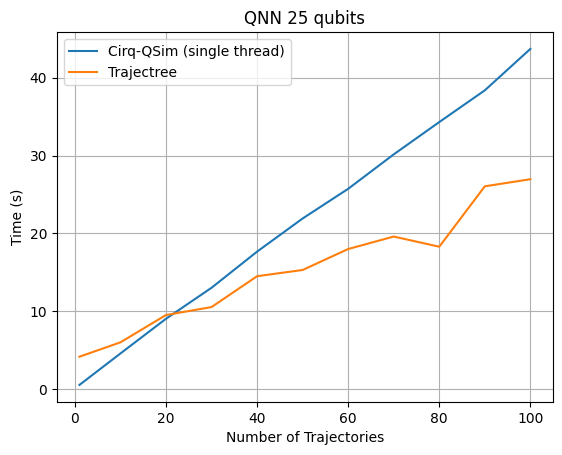

In [8]:
with open('benchmark_trajectories_analysis_qnn.json', 'r') as file:
    data = json.load(file)

num_trajectories_list = [1,10,20,30,40,50,60,70,80,90,100]

cirq_times = []
trajectree_times = []

for num_trajectories in num_trajectories_list:
    cirq_times.append(data[str(num_trajectories)][0])
    trajectree_times.append(data[str(num_trajectories)][1])

plt.plot(num_trajectories_list, cirq_times, label = "Cirq-QSim (single thread)")
plt.plot(num_trajectories_list, trajectree_times, label = "Trajectree")
plt.legend()
plt.title("QNN 25 qubits")
plt.xlabel("Number of Trajectories")
plt.ylabel("Time (s)")
plt.grid()

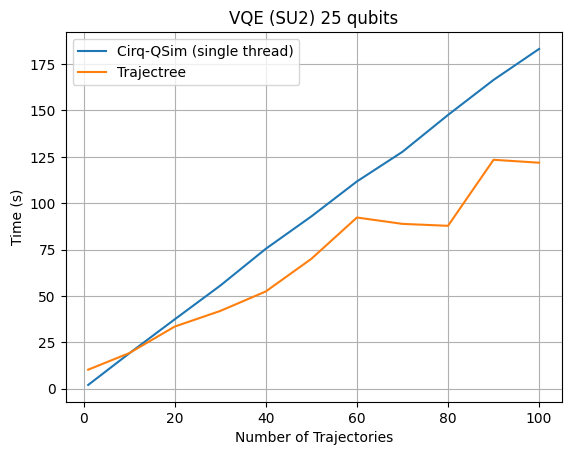

In [9]:
with open('benchmark_trajectories_analysis_vqe_su2.json', 'r') as file:
    data = json.load(file)

num_trajectories_list = [1,10,20,30,40,50,60,70,80,90,100]

cirq_times = []
trajectree_times = []

for num_trajectories in num_trajectories_list:
    cirq_times.append(data[str(num_trajectories)][0])
    trajectree_times.append(data[str(num_trajectories)][1])

plt.plot(num_trajectories_list, cirq_times, label = "Cirq-QSim (single thread)")
plt.plot(num_trajectories_list, trajectree_times, label = "Trajectree")
plt.legend()
plt.title("VQE (SU2) 25 qubits")
plt.xlabel("Number of Trajectories")
plt.ylabel("Time (s)")
plt.grid()

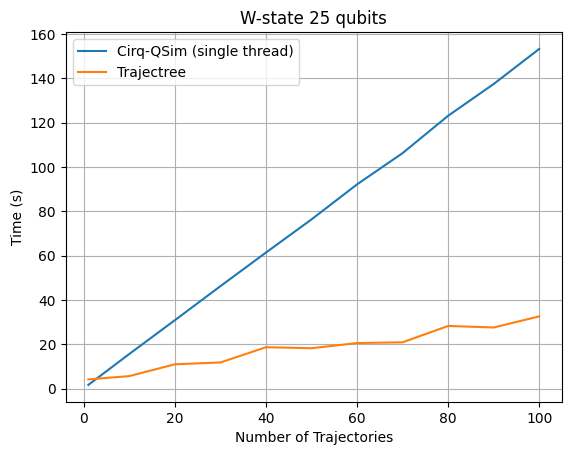

In [10]:
with open('benchmark_trajectories_analysis_wstate.json', 'r') as file:
    data = json.load(file)

num_trajectories_list = [1,10,20,30,40,50,60,70,80,90,100]

cirq_times = []
trajectree_times = []

for num_trajectories in num_trajectories_list:
    cirq_times.append(data[str(num_trajectories)][0])
    trajectree_times.append(data[str(num_trajectories)][1])

plt.plot(num_trajectories_list, cirq_times, label = "Cirq-QSim (single thread)")
plt.plot(num_trajectories_list, trajectree_times, label = "Trajectree")
plt.legend()
plt.title("W-state 25 qubits")
plt.xlabel("Number of Trajectories")
plt.ylabel("Time (s)")
plt.grid()

Params

In [13]:
target_basis = ['h', 's', 'x', 't', 'ry', 'rz', 'cx', 'cz']
num_qubits = 24
num_trajectories = 100 # This is be overrided later. 
noise_probability = 0.001

# Experiments

In [14]:
qc = create_benchmark_qc("vqe_su2", num_qubits, target_basis)
cirq_circuit, cirq_qubits = qiskit2cirq(qc, noise_probability)

# qiskit_time, qiskit_ev = run_qiskit_circuit(qc, num_qubits, num_trajectories, noise_probability, target_basis)
# print("done with qiskit")
# qsim_time, qsim_ev = run_cirq_circuit(cirq_circuit, cirq_qubits, num_qubits, num_trajectories)
# print("done with cirq")
trajectree_time, trajectree_ev = run_trajectree_circuit(qc, num_qubits, noise_probability, num_trajectories, verbose = True)

time taken: 9.825645923614502
time taken: 0.2648754119873047
time taken: 0.27039217948913574
time taken: 0.26927995681762695
time taken: 0.2942526340484619
time taken: 0.2869229316711426
time taken: 7.566954135894775
time taken: 0.27739739418029785
time taken: 0.2753782272338867
time taken: 0.2853081226348877
time taken: 0.2930948734283447
time taken: 0.3172018527984619
time taken: 0.2751173973083496
time taken: 0.2783167362213135
time taken: 0.3196237087249756
time taken: 0.30840229988098145
time taken: 5.996480703353882
time taken: 0.27900218963623047
time taken: 0.3643057346343994
time taken: 4.33638858795166
time taken: 0.32456493377685547
time taken: 0.2929706573486328
time taken: 0.3024113178253174
time taken: 3.387760877609253
time taken: 0.29781270027160645
time taken: 0.2973196506500244
time taken: 0.30964040756225586
time taken: 0.3277091979980469
time taken: 0.29514122009277344
time taken: 0.3202173709869385
time taken: 0.3441777229309082
time taken: 0.3571040630340576
time 

In [ ]:
print(qsim_time, trajectree_time)

6.876429557800293 2.114206075668335 4.398541688919067


In [9]:
all_times = {}
num_trajectories_list = [1,2]
for num_trajectories in num_trajectories_list:
    qiskit_time, qiskit_ev = run_qiskit_circuit(qc, num_qubits, num_trajectories, noise_probability, target_basis)
    print(f"done with qiskit for {num_trajectories} trajectories")
    qsim_time, qsim_ev = run_cirq_circuit(cirq_circuit, cirq_qubits, num_qubits, num_trajectories)
    print(f"done with cirq for {num_trajectories} trajectories")
    trajectree_time, trajectree_ev = run_trajectree_circuit(qc, num_qubits, noise_probability, num_trajectories, verbose = True)
    print(f"done with trajectree for {num_trajectories} trajectories")

    all_times[num_trajectories] = (qiskit_time, qsim_time, trajectree_time)

done with qiskit for 1 trajectories
done with cirq for 1 trajectories
time taken: 4.615082740783691
done with trajectree for 1 trajectories
done with qiskit for 2 trajectories
done with cirq for 2 trajectories
time taken: 4.323132514953613
time taken: 4.0957324504852295
done with trajectree for 2 trajectories


done with qiskit for 1 trajectories
done with cirq for 1 trajectories
done with trajectree for 1 trajectories
done with qiskit for 2 trajectories
done with cirq for 2 trajectories
done with trajectree for 2 trajectories
